# Pendulum Deep Ensemble

## The dataset: simple static pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the position associated with L, $\theta$, and $a_g$ using a deep ensemble.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np
import numpyro

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

## define the platform and number of cores (one chain per core)
numpyro.set_platform('cpu')
core_num = 4
numpyro.set_host_device_count(core_num)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [3]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis

In [4]:
loss_type = 'var_loss'
# options are 'no_var_loss' or 'var_loss'

## Generate pendulum data
To do this make a dataframe and replicate a bunch of columns. There are 8 pendulums on two different planets. The planet_id and pendulum_id are integers denoting which pendulum and which planet each row of the dataframe belongs.

[0.         0.02020202 0.04040404 0.06060606 0.08080808 0.1010101
 0.12121212 0.14141414 0.16161616 0.18181818 0.2020202  0.22222222
 0.24242424 0.26262626 0.28282828 0.3030303  0.32323232 0.34343434
 0.36363636 0.38383838 0.4040404  0.42424242 0.44444444 0.46464646
 0.48484848 0.50505051 0.52525253 0.54545455 0.56565657 0.58585859
 0.60606061 0.62626263 0.64646465 0.66666667 0.68686869 0.70707071
 0.72727273 0.74747475 0.76767677 0.78787879 0.80808081 0.82828283
 0.84848485 0.86868687 0.88888889 0.90909091 0.92929293 0.94949495
 0.96969697 0.98989899 1.01010101 1.03030303 1.05050505 1.07070707
 1.09090909 1.11111111 1.13131313 1.15151515 1.17171717 1.19191919
 1.21212121 1.23232323 1.25252525 1.27272727 1.29292929 1.31313131
 1.33333333 1.35353535 1.37373737 1.39393939 1.41414141 1.43434343
 1.45454545 1.47474747 1.49494949 1.51515152 1.53535354 1.55555556
 1.57575758 1.5959596  1.61616162 1.63636364 1.65656566 1.67676768
 1.6969697  1.71717172 1.73737374 1.75757576 1.77777778 1.79797

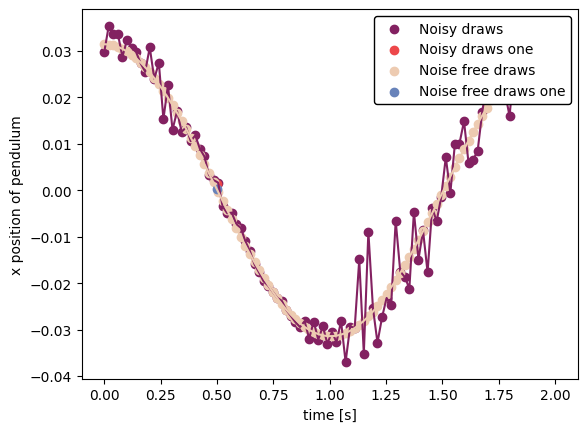

[ 0.0296734   0.03534882  0.03364137  0.03362183  0.02868884  0.03230918
  0.03065265  0.02973618  0.02729331  0.02550602  0.03071793  0.02397697
  0.02742238  0.0152703   0.02262499  0.01301601  0.0169989   0.01259291
  0.01351234  0.01055307  0.01179334  0.00893675  0.0072593   0.00328881
  0.00219095  0.00164386 -0.00346706 -0.00496212 -0.00482253 -0.00727707
 -0.00810261 -0.010997   -0.01311686 -0.01593732 -0.01770127 -0.01960435
 -0.02053477 -0.02184865 -0.02315375 -0.02381306 -0.02577806 -0.02706791
 -0.02841687 -0.02944343 -0.0281696  -0.03191166 -0.02825259 -0.03217191
 -0.02928398 -0.03303534 -0.03046434 -0.03270579 -0.02821296 -0.03694612
 -0.02933021 -0.0295989  -0.01490342 -0.03518073 -0.00894185 -0.02529892
 -0.03282171 -0.02736171 -0.02318479 -0.02474315 -0.00656028 -0.01750011
 -0.01866839 -0.02118013 -0.00463924 -0.01492774 -0.00866178 -0.01767733
 -0.00385395 -0.00664781 -0.00139899  0.00710821 -0.00058858  0.01000589
  0.01004123  0.01484667  0.0057991   0.00653612  0

In [5]:
import deepbench
from deepbench.physics_object import Pendulum

true_L = 1.0
true_theta = np.pi / 100
true_a = 9.8
percent_error = 0.1
dL = percent_error * true_L

pendulum = Pendulum(
            pendulum_arm_length=true_L,
            starting_angle_radians=true_theta,
            acceleration_due_to_gravity=true_a,
            noise_std_percent={
                "pendulum_arm_length": percent_error,
                "starting_angle_radians": 0.0,
                "acceleration_due_to_gravity": 0.0,
            },
        )

time = np.linspace(0,2,100)
print(time)
one_time = 0.5

pendulum_noisy = pendulum.create_object(time, noiseless=False)
pendulum_noiseless = pendulum.create_object(time, noiseless=True)

pendulum_noisy_one = pendulum.create_object(one_time, noiseless=False)
pendulum_noiseless_one = pendulum.create_object(one_time, noiseless=True)


plt.clf()
plt.plot(time, pendulum_noisy, color = '#832161')
plt.scatter(time, pendulum_noisy, label = 'Noisy draws', color = '#832161')
plt.scatter(one_time, pendulum_noisy_one, label = 'Noisy draws one', color = '#ED474A')
plt.plot(time, pendulum_noiseless, color = '#EDCBB1')
plt.scatter(time, pendulum_noiseless, label = 'Noise free draws', 
            color = '#EDCBB1')
plt.scatter(one_time, pendulum_noiseless_one, label = 'Noise free draws one', 
            color = '#6883BA')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.show()

print(pendulum_noisy)
print(pendulum_noiseless)


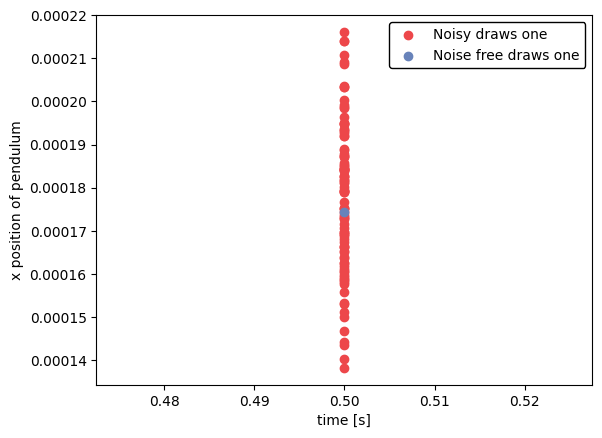

In [6]:
# okay but now do it for multiple draws from this one

true_L = 1.0
true_theta = np.pi / 100
true_a = 9.8
percent_error = 0.1
dtheta = percent_error * true_theta

pendulum = Pendulum(
            pendulum_arm_length=true_L,
            starting_angle_radians=true_theta,
            acceleration_due_to_gravity=true_a,
            noise_std_percent={
                "pendulum_arm_length": 0.0,
                "starting_angle_radians": percent_error,
                "acceleration_due_to_gravity": 0.0,
            },
        )

one_time = 0.5

pendulum_noiseless_one = pendulum.create_object(one_time, noiseless=True)


plt.clf()
for i in range(100):
    pendulum_noisy_one = pendulum.create_object(one_time, noiseless=False)
    if i == 0:
        plt.scatter(one_time, pendulum_noisy_one, label = 'Noisy draws one', color = '#ED474A')
    else:
        plt.scatter(one_time, pendulum_noisy_one, color = '#ED474A')
plt.scatter(one_time, pendulum_noiseless_one, label = 'Noise free draws one', 
            color = '#6883BA')
legend = plt.legend(loc="upper right", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.show()



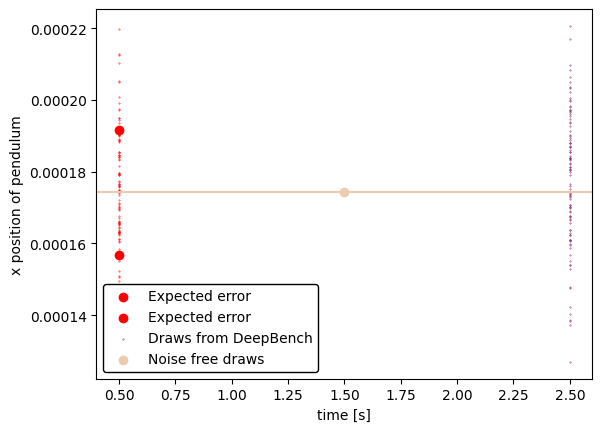

In [7]:


'''
# where noise_level is noise_std_percent 
attribute = rs.normal(
                    loc=attribute, scale=attribute * noise_level, size=n_steps
                )
# so in deepbench, noise is created by modifying the parameter value,
# using a random normal centered at the previous parameter value
# and a standard deviation which is scaled by this value multiplied by 
# the noise_level, which is effectively a true value standard deviation
'''

dx_dtheta_0 = analysis.calc_error_prop(true_L, true_theta, true_a, percent_error * true_theta, time = 0.5, wrt = 'theta_0')
plt.clf()

#plt.plot(time, pendulum_noisy, color = '#832161')

#plt.plot(time,  dx   , color = 'red', label = 'Expected error')
plt.scatter(one_time, dx_dtheta_0 + pendulum_noiseless_one, color = 'red', label = 'Expected error')
plt.scatter(one_time, -dx_dtheta_0 + pendulum_noiseless_one, color = 'red', label = 'Expected error')

# first plot the predicted scatter
for r in range(100):
    rs = np.random.RandomState()#2147483648)# 
    attribute = rs.normal(loc=0, scale=1)
    #print('random number', attribute)
    plt.scatter(one_time, attribute * dx_dtheta_0 + pendulum_noiseless_one, color = 'red', s= 0.1)#, label = 'Expected error plus gaussian random noise')
# then also doing 100 draws from the pendulum
for r in range(100):
    pendulum_noisy_one = pendulum.create_object(one_time, noiseless=False)
    if r == 0:
        plt.scatter(one_time+2, pendulum_noisy_one, color = '#832161', s = 0.1, label = 'Draws from DeepBench')
    else:
        plt.scatter(one_time+2, pendulum_noisy_one, color = '#832161', s = 0.1)#label = 'Noisy draws', 
#plt.plot(time, pendulum_noiseless, color = '#EDCBB1')

plt.scatter(one_time+1, pendulum_noiseless_one, label = 'Noise free draws', color = '#EDCBB1')
plt.axhline(y = pendulum_noiseless_one, color = '#EDCBB1')
legend = plt.legend(loc="lower left", edgecolor="black")
legend.get_frame().set_alpha(1.0)
plt.xlabel('time [s]')
plt.ylabel('x position of pendulum')
plt.show()

In [8]:
# okay now make a dataframe with a bunch of different options for the parameters
# generate the L, theta, a_g values somewhat randomly between ranges
length_percent_error_all = 0.0
theta_percent_error_all = 0.1
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.5

length_df = 1000
xs = np.zeros((length_df, 3))
y_noisy = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    length = abs(rs.normal(loc=5, scale=1))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/200))
    a_g = abs(rs.normal(loc=10, scale=2))
    xs[r,:] = [length, theta, a_g]
    
    pendulum = Pendulum(
        pendulum_arm_length=length,
        starting_angle_radians=theta,
        acceleration_due_to_gravity=a_g,
        noise_std_percent={
            "pendulum_arm_length": length_percent_error_all,
            "starting_angle_radians": theta_percent_error_all,
            "acceleration_due_to_gravity": a_g_percent_error_all,
        },
    )
    y_noisy.append(pendulum.create_object(time, noiseless=False))
    del pendulum

<Figure size 640x480 with 0 Axes>

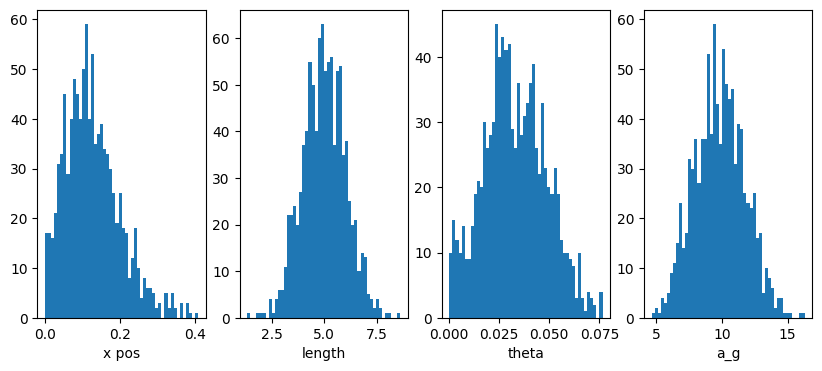

In [9]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(141)
ax.hist(y_noisy, bins=50)
ax.set_xlabel('x pos')
ax1 = fig.add_subplot(142)
ax1.hist(xs[:,0], bins=50)
ax1.set_xlabel('length')
ax2 = fig.add_subplot(143)
ax2.hist(xs[:,1], bins=50)
ax2.set_xlabel('theta')
ax3 = fig.add_subplot(144)
ax3.hist(xs[:,2], bins=50)
ax3.set_xlabel('a_g')
plt.show()

In [10]:
# we need to normalize everything
xmin = np.min(xs, axis = 0)
xmax = np.max(xs, axis = 0)

norm_xs = (xs - xmin) / (xmax - xmin)
norm_ys = (y_noisy - np.min(y_noisy)) / (np.max(y_noisy) - np.min(y_noisy))

(900, 3) (900,)
(3,)


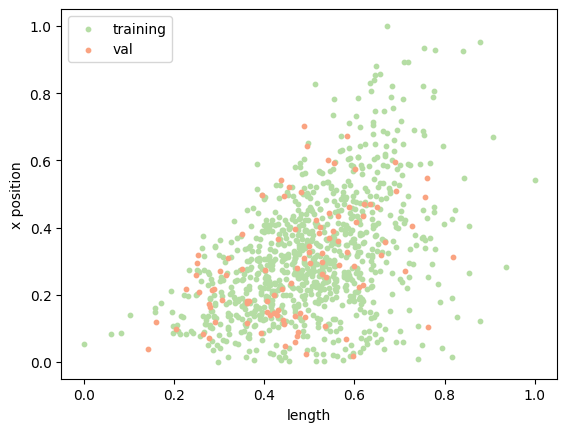

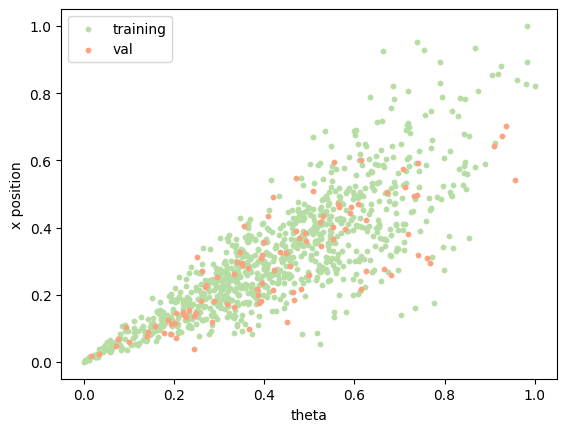

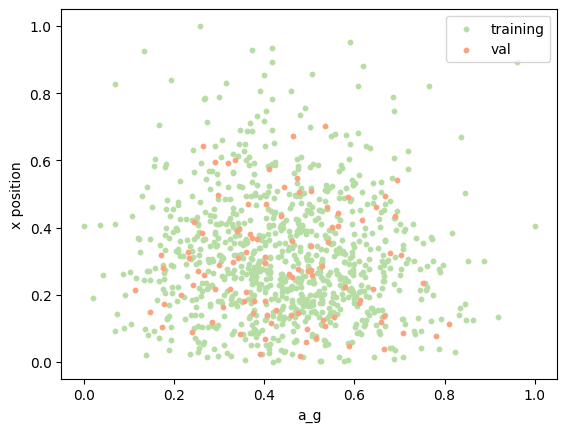

'\nSTOP\n#\n\nscaler = StandardScaler()\nscaler.fit(data)\nStandardScaler()\n>>> print(scaler.mean_)\n[0.5 0.5]\n>>> print(scaler.transform(data))\n\nx_scaler, x_train, x_val = StandardScaler(x_train, x_val)\ny_scaler, y_train, y_val = StandardScaler(y_train, y_val)\n'

In [11]:
# prepare the training, validation, and test set split:

val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(norm_xs, norm_ys, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('length')
plt.ylabel('x position')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('theta')
plt.ylabel('x position')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('a_g')
plt.ylabel('x position')
plt.show()



'''
STOP
#

scaler = StandardScaler()
scaler.fit(data)
StandardScaler()
>>> print(scaler.mean_)
[0.5 0.5]
>>> print(scaler.transform(data))

x_scaler, x_train, x_val = StandardScaler(x_train, x_val)
y_scaler, y_train, y_val = StandardScaler(y_train, y_val)
'''

In [12]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (900, 3)


In [13]:
# initialize the simple model
INIT_LR = 0.001
print("[INFO] initializing the gal model...")
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if loss_type == 'no_var_loss':
    model = models.de_no_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.MSELoss(reduction="mean")
else:
    model = models.de_var().to(device)
    # initialize our optimizer and loss function
    opt = torch.optim.Adam(model.parameters(), lr=INIT_LR)
    lossFn = torch.nn.GaussianNLLLoss(full=False, eps=1e-06, reduction="mean")
#nn.MSELoss(reduction = "mean")

[INFO] initializing the gal model...


In [14]:
print(model)

de_var(
  (ln_1): Linear(in_features=3, out_features=100, bias=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (ln_2): Linear(in_features=100, out_features=100, bias=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.1, inplace=False)
  (ln_3): Linear(in_features=100, out_features=100, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.1, inplace=False)
  (ln_4): Linear(in_features=100, out_features=2, bias=True)
)


torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([4, 3])


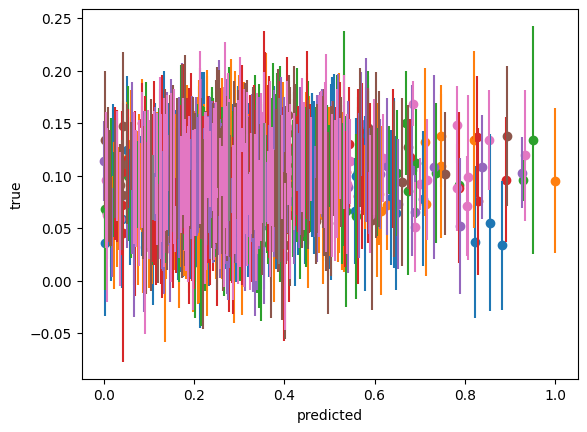

In [15]:
# plot what we're trying to predict
counter = 0
for (x, y) in trainDataLoader: # loading it up in batches
    #print('batch', counter, 'length', len(y))
    # send the input to the device
    (x, y) = (x.to(device), y.to(device))
    print(np.shape(x))
    pred_tensor = model(x)
    pred = pred_tensor.detach().numpy()
    #print(y.shape, pred.shape)
    if loss_type == 'no_var_loss':
        print(np.shape(y), np.shape(pred))
        plt.scatter(y, pred, linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor, y)
        #print('loss', loss.item())
    else:
        plt.errorbar(y, pred[:,0], yerr = abs(pred[:,1]), linestyle='None')
        plt.scatter(y, pred[:,0], linestyle='None')
        #var = torch.ones(5, 1, requires_grad=True)  # homoscedastic
        #print('var', pred[:,1])
        loss = lossFn(pred_tensor[:,0], y, pred_tensor[:,1]**2)
        #print('loss', loss.item())
    
    counter += 1
plt.xlabel('predicted')
plt.ylabel('true')
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.show()
# Interesting, before the model is trained it basically predicts the mean?

In [16]:
n_models = 10
model_ensemble = train.train_DE(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             device,
             loss_type,
             n_models,
             model_name='DE',
             EPOCHS=40,
             save_checkpoints=False,
             plot=False)
 

[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0
(100, 3)
new best mse -0.3180782198905945 in epoch 0
epoch 1 0.03
(100, 3)
new best mse -0.6347715258598328 in epoch 1
epoch 2 0.05
(100, 3)
new best mse -0.7422254681587219 in epoch 2
epoch 3 0.07
(100, 3)
new best mse -0.9266034960746765 in epoch 3
epoch 4 0.1
(100, 3)
new best mse -1.1528830528259277 in epoch 4
epoch 5 0.12
(100, 3)
new best mse -1.3840994834899902 in epoch 5
epoch 6 0.15
(100, 3)
epoch 7 0.17
(100, 3)
new best mse -1.4177980422973633 in epoch 7
epoch 8 0.2
(100, 3)
new best mse -1.4602857828140259 in epoch 8
epoch 9 0.23
(100, 3)
new best mse -1.569523811340332 in epoch 9
epoch 10 0.25
(100, 3)
new best mse -1.6373101472854614 in epoch 10
epoch 11 0.28
(100, 3)
epoch 12 0.3
(100, 3)
new best mse -1.7685681581497192 in epoch 12
epoch 13 0.33
(100, 3)
new best mse -1.9487786293029785 in epoch 13
epoch 14 0.35
(100, 3)
epoch 15 0.38
(100, 3)
epoch 16 0.4
(100, 3)
epoch 17 0.42
(100, 3

<Figure size 640x480 with 0 Axes>

0
1
2
3
4
5
6
7
8
9


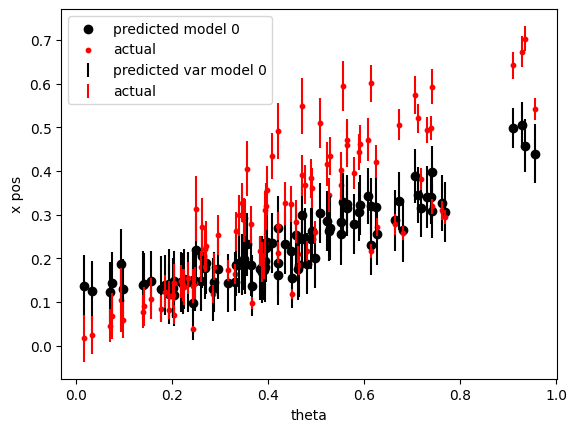

In [18]:
# there's gotta be a good way to plot the x and the y
plt.clf()

color_list = ['#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360','#C7F2A7','#FF8360']
y_pred_list = []
for m in range(n_models):
    print(m)
    
        
    
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list.append(y_pred[:,0].detach().numpy())
    if m > 0:
        continue

    if loss_type == 'no_var_loss':
        plt.scatter(x_val[:,1], y_pred.detach().numpy(),
                label = 'predicted', s = 10, color = 'black')#color = color_list[m],
    else:
        plt.scatter(x_val[:,1], y_pred[:,0].detach().numpy(),
                label = f'predicted model {m}', color = 'black', ls = 'None')#color = color_list[m],
        plt.errorbar(x_val[:,1], y_pred[:,0].detach().numpy(),
                     yerr = abs(y_pred[:,1].detach().numpy()),
                label = f'predicted var model {m}', color = 'black', ls = 'None')#color = color_list[m],
    
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual', color = 'red', ls = 'None')

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

## Now epistemic error

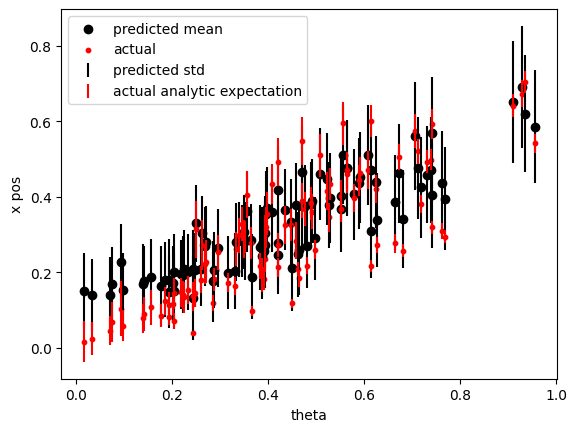

In [25]:
#print(y_pred_list)
#print(np.mean(y_pred_list, axis = 0))

plt.clf()
plt.scatter(x_val[:,1], np.mean(y_pred_list, axis = 0), label = 'predicted mean', color = 'black')
plt.errorbar(x_val[:,1], np.mean(y_pred_list, axis = 0),
             yerr = np.std(y_pred_list, axis = 0),
             label = 'predicted std', color = 'black',
             ls = 'None')
dx_dtheta = analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], 0.1, time = 0.5, wrt = 'theta_0')
#print(dx_dtheta)
plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val, yerr = dx_dtheta, label = 'actual analytic expectation', color = 'red', ls = 'None')
plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

In [21]:
# there's gotta be a good way to plot the x and the y
plt.clf()

y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)

plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (200,) into shape (100,)

<Figure size 640x480 with 0 Axes>

In [22]:
# also go through and plot the error prop uncertainty given x_val
plt.clf()



y_pred_list_array = np.zeros((np.shape(x_val)[0], n_models))
for m in range(n_models):
    model = model_ensemble[m]
    model.eval()
    y_pred = model(torch.Tensor(x_val))
    y_pred_list_array[:,m] = y_pred.detach().numpy().flatten()

sort_indices = np.argsort(x_val[:, 1])
x_val_sorted = x_val[sort_indices]
y_pred_list_sorted = y_pred_list_array[sort_indices]    
medians = np.median(y_pred_list_sorted, axis = 1).flatten()
mins = np.min(y_pred_list_sorted, axis = 1).flatten()
maxes = np.max(y_pred_list_sorted, axis = 1).flatten()

#plt.fill_between(x_val_sorted[:,1],
#                 mins,
#                 maxes,
#                 label = 'predicted')#color = color_list[m],
plt.errorbar(x_val_sorted[:,1], medians,
             yerr = [medians - mins,maxes - medians], linestyle = 'None', capsize = 5, color = 'black',
             label = 'prediction')

plt.scatter(x_val[:,1], y_val, label = 'actual', color = 'red', s = 10)
plt.errorbar(x_val[:,1], y_val,
             yerr = calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0'),
             color = 'red', ls = 'None', capsize = 5)


plt.xlabel('theta')
plt.ylabel('x pos')
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (200,) into shape (100,)

<Figure size 640x480 with 0 Axes>

In [23]:
analysis.calc_error_prop(x_val[:,0], x_val[:,1], x_val[:,2], percent_error * x_val[:,1], time = 0.5, wrt = 'theta_0')

array([0.0137553 , 0.02817591, 0.00907705, 0.00771258, 0.00827116,
       0.00619207, 0.03010447, 0.02778449, 0.00833943, 0.01019433,
       0.00519144, 0.00864805, 0.0092869 , 0.02288114, 0.02130084,
       0.02422769, 0.01782235, 0.02884236, 0.00589424, 0.02064664,
       0.01325076, 0.02864963, 0.01270191, 0.02315671, 0.01686502,
       0.02219229, 0.00661998, 0.02952112, 0.01864257, 0.03143001,
       0.00401193, 0.00920836, 0.01117295, 0.02154443, 0.02369447,
       0.01383646, 0.02673846, 0.01343814, 0.02155288, 0.01049702,
       0.00423421, 0.01656533, 0.01750644, 0.02721151, 0.00729593,
       0.00153157, 0.01426643, 0.00848486, 0.02188571, 0.02248858,
       0.02076039, 0.00631067, 0.03002075, 0.02237135, 0.00775406,
       0.01874683, 0.00091396, 0.01406391, 0.0173217 , 0.01021561,
       0.02180388, 0.02440621, 0.00689446, 0.00161942, 0.02247297,
       0.00530315, 0.01546506, 0.02255348, 0.02621434, 0.02361562,
       0.00870043, 0.01099963, 0.0215574 , 0.0053179 , 0.02639